In [241]:
!pip install imblearn shap

In [376]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import joblib
import time
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

for dirname, subfolders, files in os.walk("../input"):
    for file in files:
        print(os.path.join(dirname, file))

../input/redwinequality/winequality_red_y_train.csv
../input/redwinequality/winequality_red_x_train.csv


In [377]:
def reverse_ohe(row):
    if row['3'] == 1:
        return 3
    elif row['4'] == 1:
        return 4
    elif row['5'] == 1:
        return 5
    elif row['6'] == 1:
        return 6
    elif row['7'] == 1:
        return 7
    elif row['8'] == 1:
        return 8
# y_df['label'] = y_df.apply(reverse_ohe, axis=1)
# y_df

In [378]:
wine_red_x_train_file = "../input/redwinequality/winequality_red_x_train.csv"
wine_red_y_train_file = "../input/redwinequality/winequality_red_y_train.csv"

wine_red_x_train = pd.read_csv(wine_red_x_train_file)
wine_red_y_train = pd.read_csv(wine_red_y_train_file)

wine_red_y_train['label'] = wine_red_y_train.apply(reverse_ohe, axis=1)
wine_red_x_train['label'] = wine_red_y_train.apply(reverse_ohe, axis=1)
wine_red_df = wine_red_x_train.copy()
wine_red_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,0.690265,0.157534,0.49,0.116438,0.111853,0.366197,0.222615,0.685022,0.299213,0.251497,0.307692,6
1,0.185841,0.431507,0.01,0.102740,0.110184,0.225352,0.091873,0.398678,0.637795,0.167665,0.676923,6
2,0.176991,0.349315,0.00,0.232877,0.135225,0.704225,0.252650,0.404552,0.362205,0.071856,0.169231,5
3,0.566372,0.123288,0.58,0.082192,0.070117,0.084507,0.045936,0.582232,0.448819,0.329341,0.323077,7
4,0.336283,0.428082,0.11,0.068493,0.130217,0.211268,0.201413,0.472100,0.354331,0.293413,0.184615,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.398230,0.328767,0.00,0.068493,0.076795,0.056338,0.014134,0.560206,0.346457,0.179641,0.307692,6
1067,0.318584,0.352740,0.10,0.082192,0.101836,0.338028,0.190813,0.463289,0.433071,0.251497,0.384615,6
1068,0.230088,0.342466,0.06,0.123288,0.108514,0.197183,0.279152,0.542584,0.606299,0.125749,0.169231,5
1069,0.292035,0.054795,0.35,0.054795,0.070117,0.084507,0.031802,0.331131,0.456693,0.281437,0.538462,7


### Feature Relevance

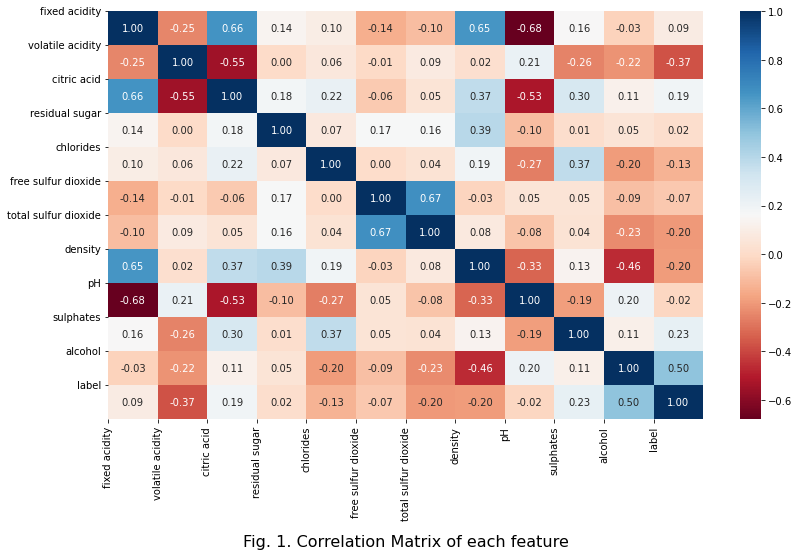

In [379]:
corr = wine_red_df.corr()
fig, ax = plt.subplots(figsize=(13.33, 7.5))

sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

fignum = 1
figtxt = ". Correlation Matrix of each feature"
figcap = "Fig. " + str(fignum) + figtxt
ax.text(0.5, -0.30, figcap, fontsize=16, ha='center', va='center', transform=ax.transAxes)

plt.show()

* citric acid -> fixed acidity
* total sulfur dioxide -> free sulfur dioxide

In [338]:
drop_features = ['fixed acidity', 'free sulfur dioxide']

wine_red_df_relevant = wine_red_df.drop(drop_features, axis=1)
wine_red_df_relevant

,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,0.157534,0.49,0.116438,0.111853,0.222615,0.685022,0.299213,0.251497,0.307692,6
1,0.431507,0.01,0.102740,0.110184,0.091873,0.398678,0.637795,0.167665,0.676923,6
2,0.349315,0.00,0.232877,0.135225,0.252650,0.404552,0.362205,0.071856,0.169231,5
3,0.123288,0.58,0.082192,0.070117,0.045936,0.582232,0.448819,0.329341,0.323077,7
4,0.428082,0.11,0.068493,0.130217,0.201413,0.472100,0.354331,0.293413,0.184615,5
...,...,...,...,...,...,...,...,...,...,...
1066,0.328767,0.00,0.068493,0.076795,0.014134,0.560206,0.346457,0.179641,0.307692,6
1067,0.352740,0.10,0.082192,0.101836,0.190813,0.463289,0.433071,0.251497,0.384615,6
1068,0.342466,0.06,0.123288,0.108514,0.279152,0.542584,0.606299,0.125749,0.169231,5
1069,0.054795,0.35,0.054795,0.070117,0.031802,0.331131,0.456693,0.281437,0.538462,7


In [339]:
# corr_matrix = wine_red_df.corr()
# corr_matrix['label'][(corr_matrix['label'] > 0.25) | (corr_matrix['label'] < -0.25)]

In [340]:
# feature_cols = list(corr_matrix['label'][(corr_matrix['label'] > 0.25) | (corr_matrix['label'] < -0.25)].index)

# wine_red_df_relevant = wine_red_df.drop(columns=[col for col in wine_red_df.columns.tolist() 
#                                      if col not in feature_cols], axis=1)
# # selected_df = selected_df[selected_df['RAD'] != 666]
# wine_red_df_relevant.head()

<AxesSubplot:xlabel='label'>

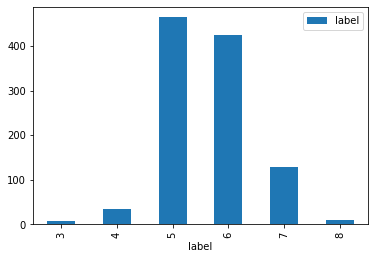

In [341]:
wine_red_df_relevant.groupby('label').agg({'label': 'count'}).plot.bar()

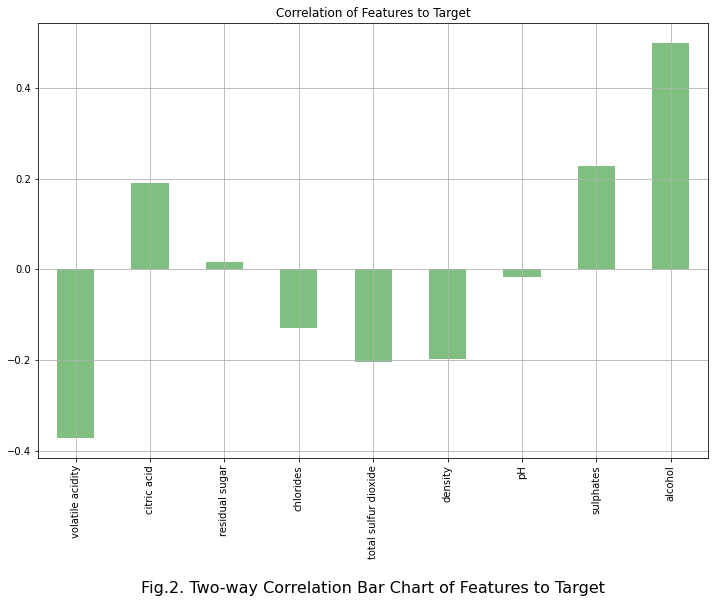

In [342]:
fig, ax = plt.subplots(1,1)
wine_red_df_relevant.drop('label', axis=1).corrwith(wine_red_df_relevant['label']).plot(kind='bar',
                                                                   grid=True, figsize=(12,8),
                                                                   title='Correlation of Features to Target',
                                                                   color='green', alpha=0.5)
fignum += 1
figtxt = ". Two-way Correlation Bar Chart of Features to Target"
figcap = "Fig." + str(fignum) + figtxt
ax.text(0.5, -0.30, figcap, fontsize=16, ha='center', va='center', transform=ax.transAxes)
plt.show()

In [415]:
X = wine_red_df.iloc[:, :-1]
y = wine_red_df.iloc[:, -1]
y_ohe = pd.get_dummies(y)

wine_red_y_train_orig = wine_red_y_train.drop('label', axis=1)
x_train0, x_test0, y_train0, y_test0 = train_test_split(wine_red_x_train, wine_red_y_train_orig, random_state=0, test_size=0.2)

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y_ohe, random_state=0, test_size=0.2)

print(x_train0.shape)
print(x_train1.shape)

(856, 12)
(856, 11)


In [416]:
y_ohe

,3,4,5,6,7,8
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
1066,0,0,0,1,0,0
1067,0,0,0,1,0,0
1068,0,0,1,0,0,0
1069,0,0,0,0,1,0


In [417]:
wine_red_y_train_orig

,3,4,5,6,7,8
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
1066,0,0,0,1,0,0
1067,0,0,0,1,0,0
1068,0,0,1,0,0,0
1069,0,0,0,0,1,0


In [419]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='not majority')

x_train_balanced, y_train_balanced = oversample.fit_resample(x_train,y_train)
x_test_balanced, y_test_balanced = oversample.fit_resample(x_test, y_test)

# y_train_balanced.value_counts().plot.bar()

In [420]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [437]:
from sklearn.metrics import f1_score

# original
clf0 = RandomForestClassifier()

clf0.fit(x_train0, y_train0)
preds0 = clf0.predict(x_test0)

print("Original f1 score: ", f1_score(y_test0, preds0, average='macro'))

# relevant
clf1 = RandomForestClassifier()

clf1.fit(x_train1, y_train1)
preds1 = clf1.predict(x_test1)

print("Relevant f1 score: ", f1_score(y_test1, preds1, average='macro'))


Original f1 score:  0.6507177033492823
Relevant f1 score:  0.3152309752425913


In [433]:
classifiers = {
    "KNeighbors": KNeighborsClassifier(),
#     "SVC": SVC(),
    "RandomForest": RandomForestClassifier(),
#     "AdaBoost": AdaBoostClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier()
}

model_evals_scaled = {
    "model": [],
    "train_score": [],
    "test_score": [],
    "f1_score": []
}

In [434]:
def plot_conf_matrix(conf_mtrx):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.matshow(conf_mtrx, cmap=plt.cm.Oranges, alpha=0.3)
    
    for i in range(conf_mtrx.shape[0]):
        for j in range(conf_mtrx.shape[1]):
            ax.text(x=j, y=i, s=conf_mtrx[i,j], va='center', ha='center', size='xx-large')
    
    plt.xlabel("Predictions", fontsize=18)
    plt.ylabel("Actuals", fontsize=18)
    plt.title("Confusion Matrix", fontsize=18)
    
    plt.show()

In [435]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.multioutput import MultiOutputClassifier

for key, classifier in classifiers.items():
    print(key)
#     classifier.fit(x_train_balanced,y_train_balanced)
#     preds = classifier.predict(x_test_balanced)
#     train_score = classifier.score(x_train_balanced, y_train_balanced)
#     classifier = MultiOutputClassifier(classifier, n_jobs=1)
    classifier.fit(x_train0, y_train0)
    preds = classifier.predict(x_test0)
    train_score = classifier.score(x_train0, y_train0)
#     rmse_ = rmse(preds, y_test)
#     precision = precision_score(y_test, preds)
#     recall = recall_score(y_test, preds)
    f1 = f1_score(y_test0, preds, average='macro')
#     test_acc = accuracy_score(y_test_balanced, preds)
    test_acc = accuracy_score(y_test0, preds)

    
    model_evals_scaled['model'].append(str(key))
    model_evals_scaled['train_score'].append(train_score.round(4))
    model_evals_scaled['test_score'].append(test_acc.round(4))
#     model_evals['rmse'].append(rmse_.round(4))
#     model_evals_balanced['precision'].append(precision.round(4))
#     model_evals_balanced['recall'].append(recall.round(4))
    model_evals_scaled['f1_score'].append(f1.round(4))
    
    
#     conf_matrix = multilabel_confusion_matrix(y_true=y_test, y_pred=preds)
#     plot_conf_matrix(conf_matrix)
    
    print()
    print('-'*60)

model_vals = pd.DataFrame(model_evals_scaled)

KNeighbors

------------------------------------------------------------
RandomForest

------------------------------------------------------------
ExtraTreesClassifier

------------------------------------------------------------


In [436]:
model_vals

,model,train_score,test_score,f1_score
0,KNeighbors,0.9988,1.0000,0.8333
1,RandomForest,1.0000,0.9860,0.6485
2,ExtraTreesClassifier,1.0000,0.9953,0.8182


### Hyperparameter Optimization

In [121]:
import lightgbm as lgb
from sklearn import pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pipe = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier())
])

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
        return {'loss': score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function,
                     param_space,
                     algo=tpe.suggest,
                     max_evals=num_eval,
                     trials=trials,
                     rstate=np.random.default_rng(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type='gbdt'
    else:
        boosting_type = 'dart'
        
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                 num_leaves=int(best_param_values[5]),
                                 max_depth=int(best_param_values[3]),
                                 n_estimators=int(best_param_values[4]),
                                 boosting_type=boosting_type,
                                 colsample_bytree=best_param_values[1],
                                 reg_lambda = best_param_values[6],
                                 )
    
    clf_best.fit(X_train, y_train)
    
    print()
    print("#### Results")
    print("Score best parameters: ", min(loss))
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [122]:
num_eval = 75 

results_hyperopt = hyperopt(param_hyperopt, x_train0, y_train0, x_test0, y_test0, num_eval)
results_hyperopt

100%|██████████| 75/75 [00:19<00:00,  3.77trial/s, best loss: 0.5654426764585884]

#### Results
Score best parameters:  0.5654426764585884
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.9597837002385726, 'learning_rate': 0.015935430097777738, 'max_depth': 9.0, 'n_estimators': 5.0, 'num_leaves': 5.0, 'reg_lambda': 0.7845606542277984}
Test Score:  0.6093023255813953
Time elapsed:  19.941309213638306
Parameter combinations evaluated:  75


In [202]:
pipe = pipeline.Pipeline([
    ('clf', ExtraTreesClassifier())
])

param_hyperopt = {
      'n_estimators': scope.int(hp.quniform('n_estimators', 10, 2000, 30)),
      'criterion': hp.choice('criterion', ['gini', 'entropy']),
      'max_depth': scope.int(hp.quniform('max_depth', 1, 90, 3)),
      'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 377, 3)),
      'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 377, 3)),
      'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.6),
      'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', 2, 5, 8, 13, 21, 34, None])
}

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    start = time.time()
    
    def objective_function(params):
        clf = ExtraTreesClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
        return {'loss': score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function,
                     param_space,
                     algo=tpe.suggest,
                     max_evals=num_eval,
                     trials=trials,
                     rstate=np.random.default_rng(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    print(best_param)
    
    clf_best = ExtraTreesClassifier(criterion=['gini', 'entropy'][best_param['criterion']],
                                   max_depth=int(best_param['max_depth']),
                                   max_features=best_param['max_features'],
                                   min_samples_leaf=int(best_param['min_samples_leaf']),
                                   min_samples_split=int(best_param['min_samples_split']),
                                   min_weight_fraction_leaf=best_param['min_weight_fraction_leaf'],
                                   n_estimators=int(best_param['n_estimators']))
    
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [203]:
num_eval = 75
results = hyperopt(param_hyperopt, x_train0, y_train0, x_test0, y_test0, num_eval)
results

100%|██████████| 100/100 [06:27<00:00,  3.87s/trial, best loss: 0.4193934448524412]
{'criterion': 1, 'max_depth': 18.0, 'max_features': 2, 'min_samples_leaf': 312.0, 'min_samples_split': 324.0, 'min_weight_fraction_leaf': 0.07780217046167841, 'n_estimators': 1980.0}

##### Results
Score best parameters:  -0.4193934448524412
Best parameters:  {'criterion': 1, 'max_depth': 18.0, 'max_features': 2, 'min_samples_leaf': 312.0, 'min_samples_split': 324.0, 'min_weight_fraction_leaf': 0.07780217046167841, 'n_estimators': 1980.0}
Test Score:  0.5534883720930233
Time elapsed:  389.5005524158478
Parameter combinations evaluated:  100


In [438]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import make_scorer

optimizer_kwargs = {'acq_func_kwargs': {"xi": 10, "kappa": 10}}

space = {
    'n_estimators': Integer( 10, 200),
      'criterion': ['gini', 'entropy'],
      'max_depth': Integer( 1, 90),
      'min_samples_split': Integer( 2, 377),
      'min_samples_leaf': Integer(1, 377),
      'min_weight_fraction_leaf': Real(0.0, 0.5, 'uniform'),
      'max_features': ['auto', 'sqrt', 'log2']
}

clf = BayesSearchCV(estimator=ExtraTreesClassifier(),
                            search_spaces=space, scoring=make_scorer(accuracy_score, greater_is_better=True),
                            n_jobs=4, n_iter=100, iid=False, optimizer_kwargs=optimizer_kwargs,
                            verbose=1)

clf.fit(x_train0, y_train0)

print("val score: %s" % clf.best_score_)
print("test score: %s" % clf.score(x_test0, y_test0))
print("best params: ", clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

val score: 0.6693934448524411 <br>
test score: 0.6883720930232559 <br>
best params:  OrderedDict([('criterion', 'gini'), ('max_depth', 56), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 200)])

In [449]:
import joblib
clf = ExtraTreesClassifier(criterion='gini', max_depth=90, max_features='sqrt', min_samples_leaf=1, 
                           min_samples_split=2, min_weight_fraction_leaf=0.0,n_estimators=200)
# clf = ExtraTreesClassifier()
clf.fit(x_train0, y_train0)

preds = clf.predict(x_test0)

model_file = "extra_trees_clf.joblib"
joblib.dump(clf, model_file)

print('accuracy: ', accuracy_score(y_test0, preds))
print('f1: ', f1_score(y_test0, preds, average='macro'))

accuracy:  0.9953488372093023
f1:  0.8325281803542673


In [450]:
etc_clf = joblib.load(os.path.join("/kaggle/working/", "extra_trees_clf.joblib"))
preds = etc_clf.predict(x_test0)
print('accuracy: ', accuracy_score(y_test0, preds))
print('f1: ', f1_score(y_test0, preds, average='macro'))

accuracy:  0.9953488372093023
f1:  0.8325281803542673


In [441]:
optimizer_kwargs = {'acq_func_kwargs': {"xi": 10, "kappa": 10}}

space = {
    'n_estimators': Integer( 10, 200),
      'criterion': ['gini', 'entropy'],
      'max_depth': Integer( 2, 90),
      'min_samples_split': Integer(2, 377),
      'min_samples_leaf': Integer(1, 10),
      'max_features': ['auto', 'log2', 'sqrt'],
}

clf = BayesSearchCV(estimator=RandomForestClassifier(),
                            search_spaces=space, scoring=make_scorer(accuracy_score, greater_is_better=True),
                            n_jobs=4, n_iter=100, iid=False, optimizer_kwargs=optimizer_kwargs,
                            verbose=1)

clf.fit(x_train0, y_train0)

print("val score: %s" % clf.best_score_)
print("test score: %s" % clf.score(x_test0, y_test0))
print("best params: ", clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [446]:
clf = RandomForestClassifier(criterion='gini', max_depth=73, max_features='log2',
                            min_samples_leaf=1, min_samples_split=2, n_estimators=200)
clf.fit(x_train0, y_train0)

preds = clf.predict(x_test0)

model_file = "random_forest_clf.joblib"
joblib.dump(clf, model_file)
print('accuracy: ', accuracy_score(y_test0, preds))
print('f1: ', f1_score(y_test0, preds, average='macro'))

accuracy:  0.9906976744186047
f1:  0.6507177033492823


In [456]:
rf_clf = joblib.load(os.path.join("/kaggle/working/", "random_forest_clf.joblib"))

preds = rf_clf.predict(x_test0)
print(preds)
print('accuracy: ', accuracy_score(y_test0, preds))
print('f1: ', f1_score(y_test0, preds, average='macro'))

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]]
accuracy:  0.9906976744186047
f1:  0.6507177033492823


array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [375]:
wine_red_y_train = wine_red_y_train.drop('label', axis=1)
x_train, x_test, y_train, y_test = train_test_split(wine_red_x_train, wine_red_y_train, random_state=0, test_size=0.2)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

clf = RandomForestClassifier(criterion='gini', max_depth=78, max_features='auto',
                            min_samples_leaf=1, min_samples_split=2, n_estimators=200)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)

# model_file = "random_forest_clf.joblib"
# joblib.dump(clf, model_file)
print('accuracy: ', accuracy_score(y_test, preds))
print('f1: ', f1_score(y_test, preds, average='macro'))

# classification_report(y_test, preds)

accuracy:  0.9906976744186047
f1:  0.6380914407230197


In [451]:
data_for_prediction = pd.DataFrame(x_test0).iloc[100]
data_for_prediction_array = data_for_prediction.values.reshape(1,-1)

etc_clf.predict_proba(data_for_prediction_array)

[array([[1., 0.]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[0.93, 0.07]]),
 array([[0.075, 0.925]]),
 array([[0.995, 0.005]])]

In [453]:
y_test0

,3,4,5,6,7,8
929,0,0,1,0,0,0
267,0,0,1,0,0,0
596,0,0,1,0,0,0
688,0,0,1,0,0,0
1069,0,0,0,0,1,0
...,...,...,...,...,...,...
436,0,0,1,0,0,0
366,0,0,1,0,0,0
682,0,0,1,0,0,0
478,0,0,0,1,0,0


In [303]:
import shap
shap.initjs()

x_test_df = pd.DataFrame(x_test_scld)
explainer = shap.TreeExplainer(rf_clf)

shap_values = explainer.shap_values(data_for_prediction_array)
shap.force_plot(explainer.expected_value[0], shap_values[0],
               data_for_prediction_array, feature_names=x_test_df.columns.tolist())

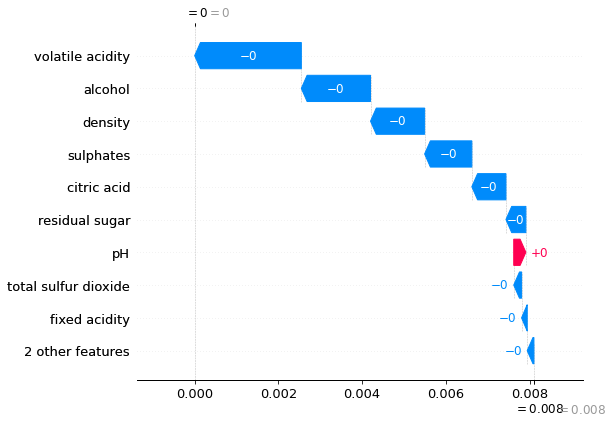

In [308]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names=x_test_df.columns.tolist())

* This took too long, the following code is no longer used

In [ ]:
from sklearn.model_selection import GridSearchCV
  
param_grid = {'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 1200, 1500, 1800, 1900, 2000, 2100, 3000], 
              'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None],
              'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'min_samples_leaf': [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              'min_weight_fraction_leaf': [x / 10 for x in range(0, 6)],
              'max_features': ['auto', 'sqrt', 'log2', 2, 5, 8, 13, 21, 34, None],
              
             }
  
grid = GridSearchCV(ExtraTreesClassifier(), param_grid, refit = True, verbose = 3)
  
grid.fit(x_train, y_train)

Fitting 5 folds for each of 2661120 candidates, totalling 13305600 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10;, score=0.523 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10;, score=0.427 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10;, score=0.579 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10;, score=0.550 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10;, score=0.579 total time=   0.0s
[CV 1/5] END criterion=